In [1]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, BooleanType, DoubleType, ArrayType
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler

from tslearn.preprocessing import TimeSeriesScalerMeanVariance

/home2/s153445/.conda/envs/thesis/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
import string
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ruptures as rpt
from collections import Counter

from wordcloud import WordCloud

In [3]:
import bayesian_changepoint_detection.online_changepoint_detection as oncd
from functools import partial
import matplotlib.cm as cm

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[18]') \
    .config("spark.driver.memory", "15g") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()

In [5]:
schema = StructType([
    StructField("bigram", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("bigram_percent", DoubleType(), True),
    StructField("medianA", DoubleType(), True),
    StructField("ntileA", IntegerType(), True),
    StructField("medianB", DoubleType(), True),
    StructField("ntileB", IntegerType(), True),
    StructField("label", IntegerType(), True),
    StructField("start_of_mainstreaming", IntegerType(), True),
    StructField("end_of_mainstreaming", IntegerType(), True),
    StructField("peak_year", IntegerType(), True),
    StructField("random_year", DoubleType(), True)])

In [6]:
df = spark.read.option('header', False).schema(schema).csv('/data/shared1/cleandata/classify_set_newer')

In [9]:
df = df.drop('medianA', 'medianB', 'start_of_mainstreaming', 'mainstreaming_year', 'end_of_mainstreaming', 'random_year')

In [10]:
df.select('bigram').distinct().count()

78744

### Prepare data

In [10]:
# collect data to an np array
dfgrouped = df.groupBy('bigram').agg(collect_list('bigram_percent').alias('percentages'),
                            collect_list('ntileB').alias('ntiles'))

signal = np.array(dfgrouped.select('percentages').collect())
bigrams = np.array(dfgrouped.select('bigram').collect())

signal_flat = np.zeros((len(signal), 120))
bigrams_flat = []

for i in range(len(signal)):
    signal_flat[i] = signal[i][0]
    bigrams_flat.append(bigrams[i][0])

In [11]:
# Normalize
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Xtranspose = np.transpose(signal_flat)

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(Xtranspose)
Xt = np.transpose(X_normalized)

###  Online changepoint detection example

In [12]:
R, maxes = oncd.online_changepoint_detection(Xt[0], partial(oncd.constant_hazard, 250), oncd.StudentT(0.1, .01, 1, 0))

In [13]:
bigrams_flat[0]

'a_noun lot_noun'

In [14]:
sparsity = 3 # only plot every third data for faster display
C = -np.log(R[0:-1:sparsity, 0:-1:sparsity])
for c in C:
    for i in range(0, len(c)):
        if str(c[i]) == 'inf':
            c[i] = 100

<ipython-input-14-a8c56bed2e37>:2: RuntimeWarning: divide by zero encountered in log
  C = -np.log(R[0:-1:sparsity, 0:-1:sparsity])


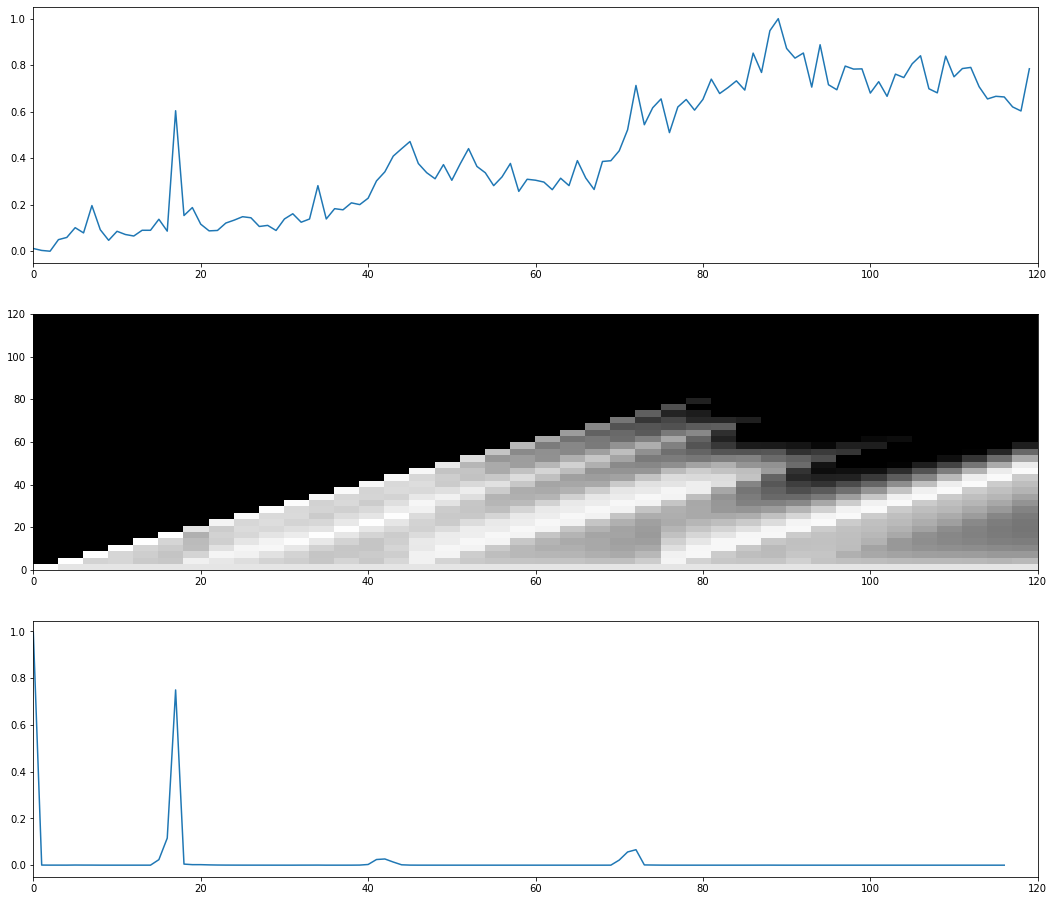

In [15]:
fig, ax = plt.subplots(figsize=[18, 16])
ax = plt.subplot(3, 1, 1)
ax.plot(Xt[0])
ax = plt.subplot(3, 1, 2, sharex=ax)
ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          C, 
          cmap=cm.Greys, vmin=0, vmax=30)
ax = plt.subplot(3, 1, 3, sharex=ax)
Nw = 3
ax.plot(R[Nw,Nw:-1])

### Online changepoint detection for all data 

In [12]:
# run online changepoint detection on all bigrams
onlineDict = dict()
for i in range(0, len(Xt)):
    R, maxes = oncd.online_changepoint_detection(Xt[i], partial(oncd.constant_hazard, 250), 
                                                 oncd.StudentT(0.1, .01, 1, 0))
    onlineDict[bigrams_flat[i]] = R

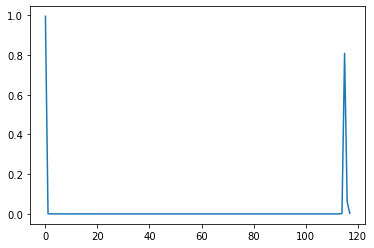

In [54]:
# Plot a bigram
plt.plot(onlineDict['convolutional_adj layer_noun'][2, 2:-1])

In [36]:
#Nw = 3
Nw = 2
selected_year = range(1990, 2018)
changepointDict = dict()
changepointYear = dict()
for key, val in onlineDict.items():
    for y in selected_year:
        if val[Nw, Nw:][y-1900] > 0.5:
            changepointDict[key] = val[Nw, Nw:][y-1900]
            changepointYear[key] = y

In [32]:
# make dataframe containing all bigrams that have large prob of changepoint in year 2000

datalist = list(zip(list(map(str, changepointDict.keys())),
                             list(map(float, changepointDict.values())),
                             list(map(int, changepointYear.values()))))
schema = StructType([
    StructField("bigram", StringType(), True),
    StructField("changepoint_prob", FloatType(), True),
    StructField("changepoint_year", IntegerType(), True)])

changepointdf = spark.createDataFrame(datalist, schema)

dfchangepoints = df.join(changepointdf, ['bigram'], how = 'inner')

In [33]:
# save dataframe
dfchangepoints.write.csv('/data/shared1/cleandata/online_changepoints_newest_14')

In [34]:
dfchangepoints.printSchema()

root
 |-- bigram: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- bigram_percent: double (nullable = true)
 |-- ntileA: integer (nullable = true)
 |-- ntileB: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- peak_year: integer (nullable = true)
 |-- changepoint_prob: float (nullable = true)
 |-- changepoint_year: integer (nullable = true)

